In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn import model_selection

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/tp/01_aprendizaje_supervisado/tp01-enunciado.ipynb)

# Trabajo Práctico -  Aprendizaje supervisado
### Clasificación de expresiones genómicas

<span style="color: red;">**Fecha de entrega: 01 de Mayo del 2024 - hasta las 23:55hs.**

<span style="color: red;">**Fecha de entrega intermedia: 25 de Abril del 2024 - hasta las 23:55hs.**
</span>

## Introducción

En el mundo actual, distintas disciplinas científicas empiezan, cada vez más, a interactuar con el fin de potenciar sus descubrimientos. En este caso dos grupos de investigación de [CONICET](https://www.conicet.gov.ar/) se embarcan en la combinación entre biología y informática para abordar la detección temprana y el pronóstico preciso de enfermedades como el cáncer. Este proyecto combina las tecnologías de secuenciación de nueva generación ([_NGS_](https://es.wikipedia.org/wiki/Secuenciaci%C3%B3n_paralela_masiva), por sus siglas en inglés) con la potencia de la inteligencia artificial. El enfoque se centra en un dataset único que abarca mediciones de [_ARN_](https://es.wikipedia.org/wiki/ARN_mensajero) de 200 [_genes_](https://es.wikipedia.org/wiki/Gen), recopiladas de pacientes con lesiones [_pre-tumorales_](https://en.wikipedia.org/wiki/Hyperplasia). Este conjunto de datos se convierte en una valiosa fuente de información para entender cómo las células en estado de hiperplasia pueden evolucionar hacia [_tumores malignos_](https://en.wikipedia.org/wiki/Neoplasm), una transformación que ha desconcertado a la ciencia durante décadas.

La hiperplasia, es un fenómeno en el que las células experimentan un crecimiento anormal y descontrolado, es un punto de partida crucial en nuestro análisis. ¿Cómo y por qué algunas células que experimentan hiperplasia se convierten en células cancerosas, mientras que otras no? Esta pregunta es el corazón de nuestra investigación. Para responderla se realizo un estudio donde se obtuvieron muestras de distintos tipos de hiperplasias de pacientes con antecedentes familiares y lesiones pre tumorales. Este grupo de pacientes, o cohorte, fue monitoreado periodicamente durante los siguientes 5 años buscando indicios de neoplasias o nuevas hiperplasias más agresivas. Con las muestras obtenidas en este estudio se realizo un [_biobanco_](https://en.wikipedia.org/wiki/Biobank) con las mediciones que habitualmente se hacen en la construccion de este tipo de [_plataformas_](https://xena.ucsc.edu/). Cada muestra fue etiquetada como **_buen pronostico_**, si no hubo indicios de nuevas hiperplasias o similares; contrariamente se etiquetaron como de **_mal pronostico_** si hubo una recaida.

Este trabajo se concentra en un panel de genes, especificamente en la expresion de 200 genes que se creen tienen un papel crucial en la transformacion tumoral y su etiqueta correspondiente.

En concreto:

Tendrán un archivo `.csv` en donde se almacenan:
  - una matriz de datos `X` de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$.
  - una columna llamada `target` que representa un vector de $500$ posiciones con dos posibles valores: `True` (ó 1, es decir, tiene buen pronostico) y `False` (ó 0, tiene mal pronostico).

Los datos están en esta [carpeta](https://github.com/aprendizaje-automatico-dc-uba-ar/material/tree/main/tp/01_aprendizaje_supervisado/datos).

Por otra parte, tendrán disponibles un conjunto de instancias sin etiquetas, que utilizaremos para comprobar la calidad de sus resultados (ver Ejercicio 5). 

**Recomendamos fuertemente leer primero todo el enunciado del trabajo antes de empezar a trabajar sobre el problema propuesto.**

---

### Sobre el informe

Para este trabajo deberán entregar, además del código de las pruebas y experimentos que realicen, un informe en el que deberan seleccionar, para cada apartado, sus resultados acompañado de un texto que explique, reflexione, justifique y conluya dicho contenido. 

Cada ejercicio indica el largo máximo del texto que se puede incluir. Los gráficos no están contados en dicho espacio. 
Cada gráfico incluido debe contar con:
  
  - nombres de los ejes,
  - título,
  - leyenda autocontenida,
  - debe ser referenciado desde el texto, ya que su inclusión se da porque aporta a la discusión del trabajo.

---

## Ejercicio 1 

### Separación de datos (máximo 2 carillas del informe)

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. 

Evaluar y justificar cómo separarán sus datos para desarrollo y para evaluación. 

**Importante**: en este punto no está permitido dividir la base de datos utilizando la función `train_test_split` de sklearn. Deben decidir e implementar la separación.

Primero cargamos los datos:

In [95]:
df = pd.read_csv("data.csv")

Veamos la proporción de datos que tienen target = 1 y de los que tienen target = 0.

In [96]:
df["target"].value_counts(normalize=True)

target
0    0.686
1    0.314
Name: proportion, dtype: float64

Elegimos separar los datos con la idea de stratified, es decir, separar los datos pero asegurarnos de que las clases queden balanceadas. Elegimos separar el 85% de los datos para desarrollo (425 datos) y el 15% de los datos (75 datos) para evaluación.

In [97]:
type(round(df["target"].value_counts()[0]*0.85))

int

Implementamos una función que nos separe según lo que queremos:

In [98]:
def stratified_split(df,prop=0.85):
    cant_0 = df["target"].value_counts()[0]
    cant_1 = df["target"].value_counts()[1]
    df_0_indices = df[df["target"]==0].index.to_list() #me quedo con los indices de los que tienen target = 0
    df_1_indices = df[df["target"]==1].index.to_list() #me quedo con los indices de los que tienen target = 1

    random.seed(4)
    prop_df_0 = random.sample(df_0_indices,round(cant_0*prop))
    menos_prop_df_0 = [idx for idx in df_0_indices if idx not in prop_df_0] 
    prop_df_1 = random.sample(df_1_indices,round(cant_1*prop))
    menos_prop_df_1 = [idx for idx in df_1_indices if idx not in prop_df_1]

    desarrollo_indices = prop_df_0+prop_df_1
    evaluacion_indices = menos_prop_df_0+menos_prop_df_1

    desarrollo = df.loc[desarrollo_indices]
    evaluacion = df.loc[evaluacion_indices]
    return desarrollo,evaluacion


Llamamos a la función para dividir los datos:

In [99]:
dev, eval = stratified_split(df)
print("Cantidad de datos en el dataset de desarrollo:", len(dev))
print("Cantidad de datos en el dataset de evaluación:",len(eval))

Cantidad de datos en el dataset de desarrollo: 425
Cantidad de datos en el dataset de evaluación: 75


Ahora veamos que se respeta la proporción original en cada uno de los datasets:

In [100]:
print("Proporción de datos del dataset de desarrollo: \n " , pd.DataFrame(dev["target"].value_counts(normalize=True)))
print("Proporción de datos del dataset de evaluación: \n ", pd.DataFrame(eval["target"].value_counts(normalize=True)))

Proporción de datos del dataset de desarrollo: 
          proportion
target            
0         0.687059
1         0.312941
Proporción de datos del dataset de evaluación: 
          proportion
target            
0             0.68
1             0.32


Guardamos los datos de desarrollo y evaluación en un nuevo archivo.

In [101]:
eval.to_csv("evaluacion.csv",index=False)
dev.to_csv("desarrollo.csv",index=False)

## Ejercicio 2


### Construcción de modelos (máximo 2 carillas del informe)

Para este punto, la tarea consiste en construir y evaluar modelos de tipo **árbol de decisión**. Además, obtener una **estimación realista de la performance** de los mismos.

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default.

1. Estimar la performance del modelo utilizando _K-fold cross validation_ con `K=5`, con las métricas _Accuracy_, _Area Under the Precision-Recall Curve (AUPRC)_., _Area Under the Receiver Operating Characteristic Curve (AUCROC)_. 

   En esta oportunidad se va a pedir además de calcular las métricas para cada fold por separado y su promedio, que hagan el cálculo del score global (como vimos en clase), sólo para los folds de validación.
   
   Reportar el resultado en una tabla similar a:

      <table>
      <thead>
      <tr>
      <th align="center">Permutación</th>
      <th>Accuracy (training)</th>
      <th>Accuracy (validación)</th>
      <th>AUPRC (training)</th>
      <th>AUPRC (validación)</th>
      <th>AUC ROC (training)</th>
      <th>AUC ROC (validación)</th>
      </tr>
      </thead>
      <tbody>
      <tr>
      <td align="center">1</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">2</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">3</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">4</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">5</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">Promedios</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <td align="center">Global</td>
      <td>(NO) </td>
      <td></td>
      <td>(NO) </td>
      <td></td>
      <td>(NO) </td>
      <td></td>
      </tr>
      </tbody>
      </table>    
  
   **Importante**: de acá en más sólamente utilizaremos el score promedio cuando hagamos _K-fold cross-validation_.
 
1. Explorar las siguientes combinaciones de parámetros para  árboles de decisión (siguiendo con $k-fold$ con $k=5$) utilizando [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) de _scikit learn_. No está permitido utilizar `GridSearchCV` en este ejercicio.

   <table>
   <thead>
   <tr>
   <th align="center">Altura máxima</th>
   <th align="center">Criterio de corte</th>
   <th>Accuracy (training)</th>
   <th>Accuracy (validación)</th>
   </tr>
   </thead>
   <tbody><tr>
   <td align="center">3</td>
   <td align="center">Gini</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">5</td>
   <td align="center">Gini</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">Infinito</td>
   <td align="center">Gini</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">3</td>
   <td align="center">Entropía</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">5</td>
   <td align="center">Entropía</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">Infinito</td>
   <td align="center">Entropía</td>
   <td></td>
   <td></td>
   </tr>
   </tbody></table>


1. ¿Qué conclusiones se pueden sacar de estas tablas?  

#### 1. Entrenamos un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default.

In [102]:
from sklearn.tree import DecisionTreeClassifier

Separamos los datos de desarollo en train y test.

In [103]:
data = pd.read_csv("desarrollo.csv")

x_train, x_test, y_train, y_test = model_selection.train_test_split(
                    data[data.columns.difference(['target'])],
                    data['target'],
                    random_state=4,
                    test_size=0.1)

Entrenamos y vemos la performance del modelo

In [104]:
arbol = DecisionTreeClassifier(max_depth=3)
arbol.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [105]:
print("El accuracy para el conjunto de datos de entrenamiento es:", arbol.score(x_train, y_train))
print("El accuracy para el conjunto de datos de test es:" , arbol.score(x_test, y_test))

El accuracy para el conjunto de datos de entrenamiento es: 0.7905759162303665
El accuracy para el conjunto de datos de test es: 0.5813953488372093


#### 2. Estimamos la performance del modelo utilizando _K-fold cross validation_ con `K=5`, con las métricas _Accuracy_, _Area Under the Precision-Recall Curve (AUPRC)_., _Area Under the Receiver Operating Characteristic Curve (AUCROC)_. 

In [106]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, auc, precision_recall_curve, roc_auc_score

Definimos las funciones para entrenar, predecir y medir la performance para un árbol de decisión

In [107]:
def train_tree(X_tr: np.ndarray, y_tr: np.ndarray, tree_params={}) -> DecisionTreeClassifier:
    arbol = DecisionTreeClassifier(**tree_params) #crea el árbol con los hiperparametros deseados
    arbol.fit(X_tr, y_tr)

    return arbol

def tree_predict(ab: DecisionTreeClassifier, X_test: np.ndarray) -> np.ndarray:
    predictions = ab.predict(X_test) #recibe el árbol ya entrenado y te devuelve las predicciones
    return predictions

def metricas_seleccionadas(y_pred, y_real): # calcula las métricas deseadas
    precision, recall, _ = precision_recall_curve(y_real,y_pred) 
    return accuracy_score(y_real, y_pred), auc(precision, recall), roc_auc_score(y_real, y_pred)

A partir de ahora vamos a usar todos los datos que tenemos para entrenar, unimos los que habíamos separado en el ejercicio 2.1.

In [108]:
x = pd.concat([x_train, x_test])
y = pd.concat([y_train, y_test])

Hacemos stratified K-fold cross-validation con K=5, donde devolvemos las métricas pedidas.

In [109]:
y_pred = np.empty(y.shape) #creamos el vector para las predicciones globales
y_pred.fill(np.nan)
accuracy_folds_train = np.array([])
aupcr_folds_train = np.array([])
aucroc_folds_train = np.array([])
accuracy_folds_test = np.array([])
aupcr_folds_test = np.array([])
aucroc_folds_test = np.array([])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

for train_index, test_index in skf.split(x, y):
    #en train_index estan los indices de los datos que estan en los 5 folds que pertenecen a training
    #en test_index estan los indices de los datos que estan en el unico fold que es el test
    
    #separamos el fold que no uso para entrenar como fold de test
    kf_X_train, kf_X_test = x.iloc[train_index], x.iloc[test_index]
    kf_y_train, kf_y_test = y.iloc[train_index], y.iloc[test_index]

    current_tree = train_tree(kf_X_train, kf_y_train,
                                tree_params={"max_depth":3})
    predictions_train = tree_predict(current_tree, kf_X_train)
    predictions_test = tree_predict(current_tree, kf_X_test)
    y_pred[test_index] = predictions_test #quedan algunos vacios (con NAs) en cada iteracion pero finalmente se llena todo
    
    accuracy_fold_train, aupcr_fold_train, aucroc_fold_train = metricas_seleccionadas(predictions_train, kf_y_train)
    accuracy_fold_test, aupcr_fold_test, aucroc_fold_test = metricas_seleccionadas(predictions_test, kf_y_test)
    
    accuracy_folds_train = np.append(accuracy_folds_train, accuracy_fold_train)
    accuracy_folds_test = np.append(accuracy_folds_test,accuracy_fold_test)
    aupcr_folds_train = np.append(aupcr_folds_train, aupcr_fold_train)
    aupcr_folds_test = np.append(aupcr_folds_test,aupcr_fold_test)
    aucroc_folds_train = np.append(aucroc_folds_train, aucroc_fold_train) 
    aucroc_folds_test = np.append(aucroc_folds_test, aucroc_fold_test)

accuracy_global, aupcr_global, aucroc_global = metricas_seleccionadas(y_pred, y) #calculo las metricas deseadas

Creamos un dataframe para conseguir la tabla con las distintas las metricas

In [110]:
df_metrics = pd.DataFrame({
    "fold": np.arange(1,6),
    "accuracy_train": accuracy_folds_train,
    "accuracy_test": accuracy_folds_test,
    "aupcr_train": aupcr_folds_train,
    "aupcr_test": aupcr_folds_test,
    "aucroc_train": aucroc_folds_train,
    "aucroc_test": aucroc_folds_test
})

promedios = np.array(["promedio"])
for column in df_metrics.columns[1:]:
    promedio = df_metrics[column].mean()
    promedios = np.append(promedios, round(promedio,6))


df_metrics.loc[5] = promedios
#agregar las metricas globales
df_metrics.loc[6] = ["global", np.nan, accuracy_global, np.nan, aupcr_global, np.nan, aucroc_global]

df_metrics

,fold,accuracy_train,accuracy_test,aupcr_train,aupcr_test,aucroc_train,aucroc_test
0,1,0.835294,0.682353,0.460067,0.24724,0.78633,0.6206
1,2,0.835294,0.635294,0.460067,0.144322,0.78633,0.543677
2,3,0.826471,0.694118,0.446895,0.242079,0.775883,0.617497
3,4,0.841176,0.705882,0.469634,0.245316,0.786567,0.61622
4,5,0.838235,0.741176,0.464955,0.349095,0.794751,0.711367
5,promedio,0.835294,0.691765,0.460324,0.24561,0.785972,0.621872
6,global,NaN,0.691765,NaN,0.247725,NaN,0.622155


#### 3. Exploramos las siguientes combinaciones de parámetros para árboles de decisión (siguiendo con $k-fold$ con $k$=5) utilizando [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) de _scikit learn_.

In [111]:
from sklearn.model_selection import ParameterGrid

Definimos la función SF_Cross_Validation que recibe un diccionario con todos los parametros con los que deseamos entrenar el arbol.

In [112]:
def SF_Cross_Validation(params):
    y_pred = np.empty(y.shape) 
    y_pred.fill(np.nan)
    accuracy_folds_train = np.array([])
    accuracy_folds_test = np.array([])
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

    for train_index, test_index in skf.split(x, y):
        #en train_index estan los indices de los datos que estan en los 5 folds que pertenecen a training
        #en test_index estan los indices de los datos que estan en el unico fold que es el test
        
        #saco el fold que no uso para entrenar
        kf_X_train, kf_X_test = x.iloc[train_index], x.iloc[test_index]
        kf_y_train, kf_y_test = y.iloc[train_index], y.iloc[test_index]

        current_tree = train_tree(kf_X_train, kf_y_train,
                                    tree_params=params)
        predictions_train = tree_predict(current_tree, kf_X_train)
        predictions_test = tree_predict(current_tree, kf_X_test)
        y_pred[test_index] = predictions_test #quedan algunos vacios (con NAs) en cada iteracion pero finalmente se llena todo
        
        accuracy_fold_train = accuracy_score(kf_y_train, predictions_train)
        accuracy_fold_test = accuracy_score(kf_y_test, predictions_test)
        
        accuracy_folds_train = np.append(accuracy_folds_train, accuracy_fold_train)
        accuracy_folds_test = np.append(accuracy_folds_test,accuracy_fold_test)
    return np.mean(accuracy_folds_train), np.mean(accuracy_folds_test)

Creamos un dataframe para conseguir la tabla con los distintos hiperparámetros que analizamos

In [113]:
profundidades = [3,5,None]
metricas = ["gini", "entropy"]

def crear_grilla(profundidades, metricas):
    parametros = {
        'max_depth': profundidades,
        'criterion': metricas
    }
    grilla = list(ParameterGrid(parametros))
    return grilla

grilla_parametros = crear_grilla(profundidades, metricas)


# Crear un DataFrame para almacenar los resultados
resultados = pd.DataFrame(columns=['Altura máxima', 'Criterio de corte', 'Accuracy (training)', 'Accuracy (validación)'])
i = 1
for params in grilla_parametros:
    max_depth = params['max_depth']
    criterion = params['criterion']
    accuracy_train, accuracy_val = SF_Cross_Validation(params)
    resultados.loc[i, 'Altura máxima'] = str(max_depth) if max_depth is not None else 'Infinito'
    resultados.loc[i, 'Criterio de corte'] = criterion.capitalize()
    resultados.loc[i, 'Accuracy (training)'] = accuracy_train
    resultados.loc[i, 'Accuracy (validación)'] = accuracy_val
    i = i + 1

In [114]:
resultados

,Altura máxima,Criterio de corte,Accuracy (training),Accuracy (validación)
1,3,Gini,0.835294,0.691765
2,5,Gini,0.937647,0.658824
3,Infinito,Gini,1.0,0.632941
4,3,Entropy,0.805882,0.689412
5,5,Entropy,0.9,0.677647
6,Infinito,Entropy,1.0,0.68


## Ejercicio 3

### Comparación de algoritmos 

Se pide explorar distintas combinaciones de algoritmos de aprendizaje con diferentes configuraciones con el objetivo de encontrar el mejor modelo de cada familia de buscar la performance óptima. Para este ejercicio realizar una experimentación utilizando [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Como métrica de performance usar AUCROC resultante de 5-fold cross-validation. 

Algoritmos a probar: 
  - Árboles de decisión
  - KNN (k-vecinos más cercanos)
  - SVM (Support vector machine)
  - LDA (Linear discriminant analysis)
  - Naïve Bayes
  
_Hiperparámetros_: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras. 

Documentación extra sobre [`Tuning hyper-parameters`](https://scikit-learn.org/stable/modules/grid_search.html), leer hasta 3.2.2.

Para este ejercicio se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

Para cada método pueden incluir hasta media carilla de texto y los gráficos que considere relevantes.

In [115]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from scipy.stats import uniform, randint

Definimos los diccionarios con hiperparámetros para los distintos modelos

In [116]:
# árbol de decisión
arbol = DecisionTreeClassifier()
dic_arbol = {
    'max_depth': randint(1, 10), #distribucion uniforme entera entre 1 y 10
    'criterion': ['gini', 'entropy', 'log_loss']
}

# k neighbors n
knn_classifier = KNeighborsClassifier()
dic_knn = {
    'n_neighbors': randint(1, 20), #numero de vecinos
    'weights': ['uniform', 'distance'], #pesos: cuando hacen la votación pueden tener todos el mismo peso = uniforme, 
                                        #o tener pesos distintos en función de la distancia = distance
    'p': [1, 2] #distancia de minkowski (como se mide la distancia) p = 1 = manhattan y p = 2 = ecuclidiana 
}

#support vector machine
svm_classifier = svm.SVC()
dic_svm = {
    'C': uniform(0, 6), #el C restringe las instancias que pueden caer en el lado incorrecto
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], #el kernel con el que cambiamos la dimension
                                                    #lineal
                                                    #poly: abajo aclaramos el grado
                                                    #rbf: radial (el de los circulos)
                                                    #sigmoid 
    'degree': randint(2, 11) #aclara el grado del polinomico, sino lo ignora
}


#linear discriminant analysis
lda_classifier = LinearDiscriminantAnalysis() #no tiene parametros
dic_lda = {
}

#naive bayes
naive_bayes_classifier = GaussianNB()
dic_naive_bayes = { 
    'var_smoothing': uniform(0.000001, 0.001) , #suaviza la matriz de covarianza
    'priors': np.array([[0.68,0.32],[0.32,0.68],[0.85,0.15],[0.5,0.5],[0.15,0.85],[0.7,0.3],[0.3,0.7]]) #probabilidades a priori
    }

In [117]:
def randomized_search(modelo, parametros,x,y, iter):
    random_search = RandomizedSearchCV(estimator=modelo, param_distributions=parametros, n_iter=iter,
                                    scoring='roc_auc', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                    verbose=0, random_state=41, n_jobs=-1)
    return random_search.fit(x, y)

Llamamos a la función para cada modelo

In [118]:
modelos = [arbol, knn_classifier, svm_classifier, lda_classifier, naive_bayes_classifier]
dic = [dic_arbol, dic_knn, dic_svm, dic_lda, dic_naive_bayes]
cantidad_iteraciones = [15, 30, 40, 1, 20]

top5 = pd.DataFrame(columns=["Modelo", "mean_AUROC", "parametros"])

for i in range(0,5):
    resultados = randomized_search(modelos[i], dic[i], x, y, cantidad_iteraciones[i])
    parametros_probados = pd.DataFrame(resultados.cv_results_)
    parametros_probados = parametros_probados[['params', 'mean_test_score']]
    parametros_ordenados = parametros_probados.sort_values(by='mean_test_score', ascending=False)
    parametros_seleccionados = parametros_ordenados.head(5).copy()  # Crear una copia del DataFrame
    
    parametros_seleccionados["Modelo"] = str(modelos[i])
    parametros_seleccionados = parametros_seleccionados.rename(columns={"mean_test_score": "mean_AUROC", "params": "parametros"})

    top5 = pd.concat([top5, parametros_seleccionados], ignore_index=True)  # Usar ignore_index=True para reindexar el DataFrame resultante


Veamos para cada modelo los 5 que tuvieron mejor valor de área bajo la curva roc

In [119]:
#Primero redondeamos el valor de C
for i in range(0,21):
    if top5.at[i, "Modelo"] == "SVC()":
        parameter = top5.loc[i, "parametros"]
        top5.at[i, "parametros"] = {'C': round(parameter["C"],3) , 'degree' : parameter["degree"],'kernel' : parameter['kernel']}

top5

,Modelo,mean_AUROC,parametros
0,DecisionTreeClassifier(),0.646762,"{'criterion': 'entropy', 'max_depth': 3}"
1,DecisionTreeClassifier(),0.646762,"{'criterion': 'entropy', 'max_depth': 3}"
2,DecisionTreeClassifier(),0.624257,"{'criterion': 'gini', 'max_depth': 2}"
3,DecisionTreeClassifier(),0.623148,"{'criterion': 'log_loss', 'max_depth': 2}"
4,DecisionTreeClassifier(),0.622302,"{'criterion': 'gini', 'max_depth': 3}"
5,KNeighborsClassifier(),0.842864,"{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}"
6,KNeighborsClassifier(),0.839378,"{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}"
7,KNeighborsClassifier(),0.830942,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}"
8,KNeighborsClassifier(),0.829063,"{'n_neighbors': 16, 'p': 1, 'weights': 'uniform'}"
9,KNeighborsClassifier(),0.829063,"{'n_neighbors': 16, 'p': 1, 'weights': 'uniform'}"


Veamos el orden de los modelos según su area bajo la curva roc

In [120]:
top5.sort_values(by='mean_AUROC', ascending=False)

,Modelo,mean_AUROC,parametros
10,SVC(),0.891996,"{'C': 4.344, 'degree': 4, 'kernel': 'rbf'}"
11,SVC(),0.891876,"{'C': 4.088, 'degree': 7, 'kernel': 'rbf'}"
12,SVC(),0.891727,"{'C': 5.686, 'degree': 8, 'kernel': 'rbf'}"
13,SVC(),0.891490,"{'C': 3.983, 'degree': 4, 'kernel': 'rbf'}"
14,SVC(),0.879929,"{'C': 1.686, 'degree': 6, 'kernel': 'rbf'}"
5,KNeighborsClassifier(),0.842864,"{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}"
6,KNeighborsClassifier(),0.839378,"{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}"
7,KNeighborsClassifier(),0.830942,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}"
8,KNeighborsClassifier(),0.829063,"{'n_neighbors': 16, 'p': 1, 'weights': 'uniform'}"
9,KNeighborsClassifier(),0.829063,"{'n_neighbors': 16, 'p': 1, 'weights': 'uniform'}"


## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza.

<span style="color: red;">(no realizar hasta la clase _Sesgo y Varianza_)</span>

En este punto, se pide inspeccionar **tres** de sus mejores modelos encontrados hasta ahora de cada familia de modelos: la mejor configuración para el árbol de decisión, la mejor configuración para LDA y la mejor configuración para SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo (excepto para LDA), variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo **RandomForest** con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos.


**Atención**: Tener en cuenta que debemos seguir utilizando AUC ROC como métrica para estas curvas.

Para cada método pueden incluir hasta una carilla de texto y los gráficos que considere relevantes.


#### 1. Graficamos curvas de complejidad para cada modelo (excepto para LDA), variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. 

In [121]:
from sklearn.model_selection import cross_validate

Nos quedamos con el mejor modelo de cada familia

In [122]:
mejor_modelo_arbol = top5[0:1]
mejor_modelo_svm = top5[10:11] 
mejor_modelo_knn = top5[5:6]
mejor_modelo_bayes = top5[16:17]
mejor_modelo_lda = top5[15:16] 

mejor_modelo = pd.concat([mejor_modelo_svm,mejor_modelo_arbol,mejor_modelo_lda], ignore_index=True)
mejor_modelo

,Modelo,mean_AUROC,parametros
0,SVC(),0.891996,"{'C': 4.344, 'degree': 4, 'kernel': 'rbf'}"
1,DecisionTreeClassifier(),0.646762,"{'criterion': 'entropy', 'max_depth': 3}"
2,LinearDiscriminantAnalysis(),0.753419,{}


Definimos la función auroc_complejidad que recibe un modelo y sus parametros y devuelve el auc roc.

In [123]:
def auroc_complejidad(modelo, params):
    model = modelo(**params)
    result = cross_validate(model, x, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=4),scoring='roc_auc',return_train_score=True)
    result_train = np.mean(result["train_score"])
    result_test = np.mean(result["test_score"])

    return result_train, result_test

##### Graficamos las curvas de complejidad para cada uno de los modelos deseados.

##### Árbol de decisión

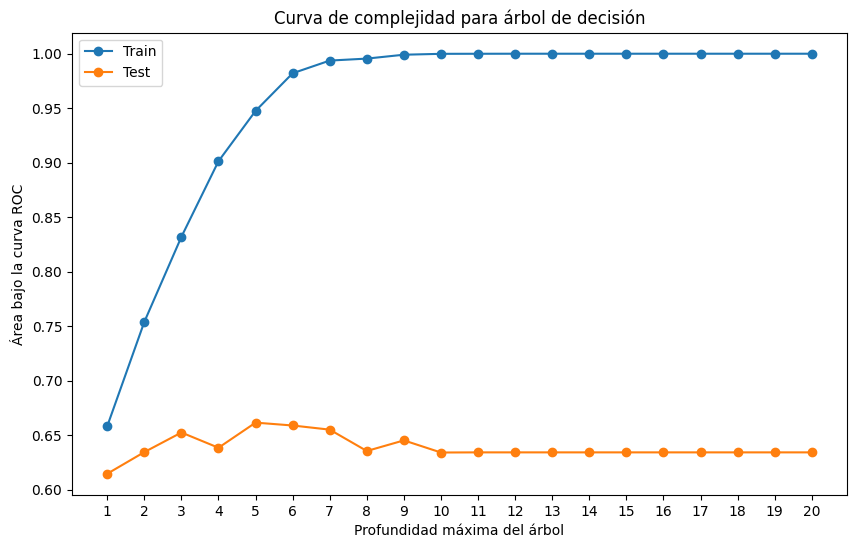

In [124]:
max_depth_values = range(1, 21)

# Inicializamos listas para almacenar las puntuaciones de entrenamiento y prueba
train_auroc = []
test_auroc = []

# Calculamos puntuaciones para cada valor de profundidad máxima
for max_depth in max_depth_values:
    auroc_promedio_train, auroc_promedio_test = auroc_complejidad(DecisionTreeClassifier, {"max_depth": max_depth, "criterion": "entropy", "random_state": 4})
    train_auroc.append(auroc_promedio_train)
    test_auroc.append(auroc_promedio_test)


# Graficamos las curvas de complejidad
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_auroc, label='Train', marker='o')
plt.plot(max_depth_values, test_auroc, label='Test', marker='o')
plt.xticks(range(1, 21))
plt.xlabel('Profundidad máxima del árbol')
plt.ylabel('Área bajo la curva ROC')
plt.title('Curva de complejidad para árbol de decisión')
plt.legend()
plt.show()

##### Support Vector Machine:

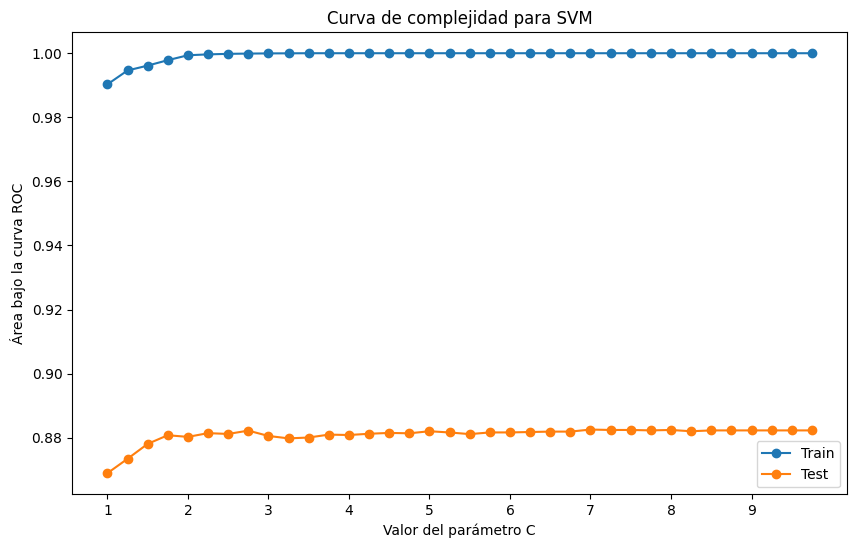

In [125]:
c_values = np.arange(1,10, 0.25)

# Inicializamos listas para almacenar las puntuaciones de entrenamiento y prueba
train_auroc = []
test_auroc = []

# Calculamos puntuaciones para cada valor de profundidad máxima
for C in c_values:
    auroc_promedio_train, auroc_promedio_test = auroc_complejidad(svm.SVC, params={'C': C, 'kernel': 'rbf',"random_state": 4})
    train_auroc.append(auroc_promedio_train)
    test_auroc.append(auroc_promedio_test)


# Graficamos las curvas de complejidad
plt.figure(figsize=(10, 6))
plt.plot(c_values, train_auroc, label='Train', marker='o')
plt.plot(c_values, test_auroc, label='Test', marker='o')
plt.xlabel('Valor del parámetro C')
plt.ylabel('Área bajo la curva ROC')
plt.title('Curva de complejidad para SVM')
plt.xticks(np.arange(1,10, 1))

plt.legend()
plt.show()

In [126]:
print('Podemos ver que el mejor valor de C se alcanza en: ', c_values[np.argmax(test_auroc)])

Podemos ver que el mejor valor de C se alcanza en:  7.0


##### 2. Graficamos curvas de aprendizaje para cada modelo

In [127]:
from sklearn.model_selection import LearningCurveDisplay

##### Árbol de decisión:

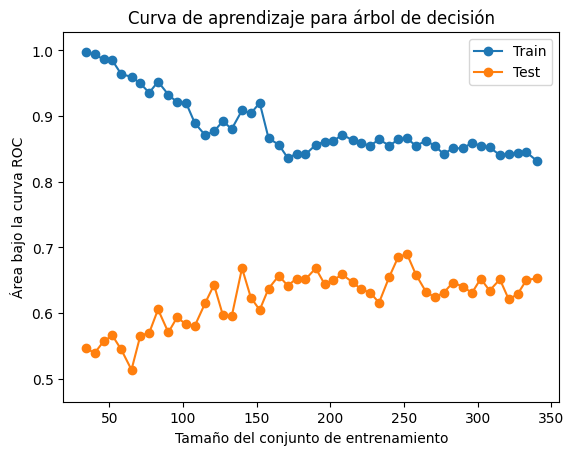

In [128]:

arbol = DecisionTreeClassifier(**mejor_modelo_arbol['parametros'].values[0])
play = LearningCurveDisplay.from_estimator(arbol, x, y, train_sizes = np.linspace(0.1, 1.0, 50), line_kw = {"marker": "o"}, cv=skf, scoring='roc_auc')

ax = plt.gca()

for collection in ax.collections:
    collection.set_alpha(0)

plt.title('Curva de aprendizaje para árbol de decisión')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Área bajo la curva ROC')
plt.show()

##### Support Vector Machine:

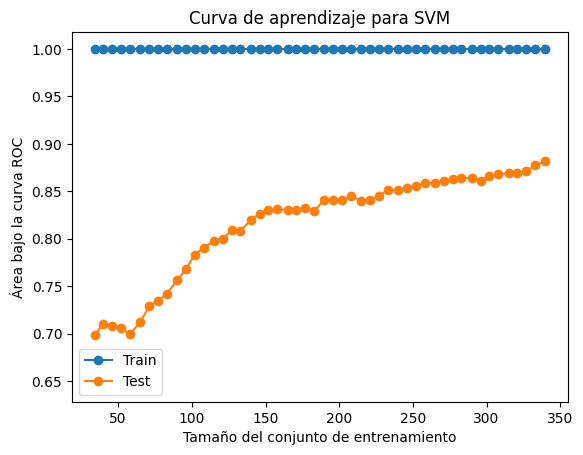

In [129]:
SVM = svm.SVC(**mejor_modelo_svm['parametros'].values[0])
play = LearningCurveDisplay.from_estimator(SVM, x, y, train_sizes = np.linspace(0.1, 1.0, 50), cv=skf, line_kw = {"marker": "o"}, scoring='roc_auc')

ax = plt.gca()

for collection in ax.collections:
    collection.set_alpha(0)

plt.title('Curva de aprendizaje para SVM')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Área bajo la curva ROC')
plt.show()

##### linear discriminant analysis

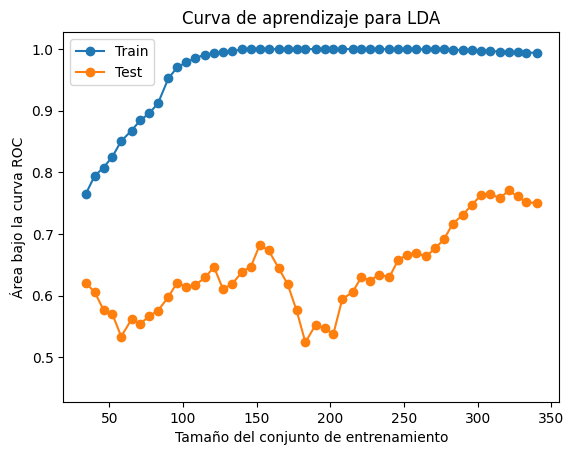

In [130]:
LDA = LinearDiscriminantAnalysis(**mejor_modelo_lda['parametros'].values[0])
play = LearningCurveDisplay.from_estimator(LDA, x, y, train_sizes = np.linspace(0.1, 1.0, 50), cv=skf, line_kw = {"marker": "o"}, scoring='roc_auc')

ax = plt.gca()

for collection in ax.collections:
    collection.set_alpha(0)

plt.title('Curva de aprendizaje para LDA')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Área bajo la curva ROC')
plt.show()

##### 3. Construimos un modelo **RandomForest** con 200 árboles. Exploramos para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Por último, graficamos una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos.

In [131]:
from sklearn.ensemble import RandomForestClassifier

Entrenamos el RandomForest con 200 árboles

In [132]:
random_forest = RandomForestClassifier(n_estimators = 200)

random_forest.fit(x, y)

RandomForestClassifier(n_estimators=200)

Veamos la curva de complejidad 

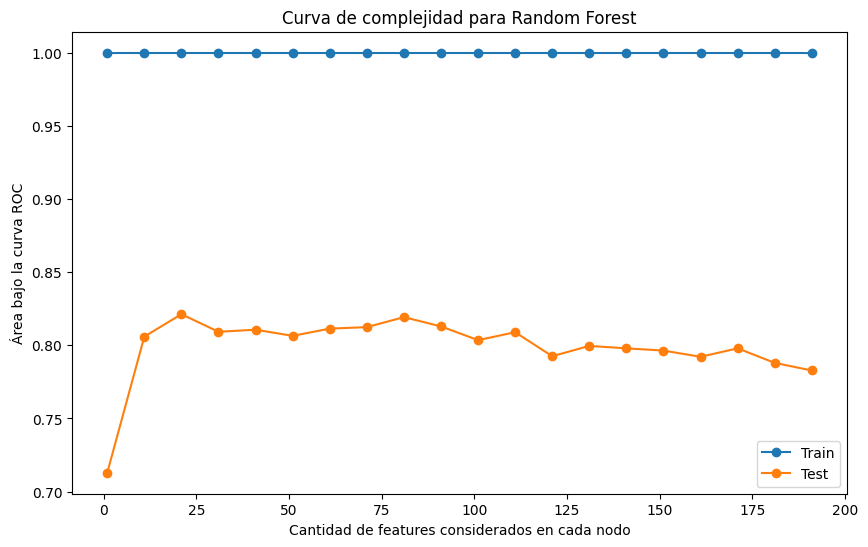

In [133]:
train_auroc_rf = []
test_auroc_rf = []
cant_features = range(1,201, 10)

for feature in cant_features:
    train_auroc, test_auroc = auroc_complejidad(RandomForestClassifier, params={"max_features": feature, "n_estimators": 200})
    train_auroc_rf = np.append(train_auroc_rf, train_auroc)
    test_auroc_rf = np.append(test_auroc_rf, test_auroc)


plt.figure(figsize=(10, 6))
plt.plot(cant_features, train_auroc_rf, label='Train', marker='o')
plt.plot(cant_features, test_auroc_rf, label='Test', marker='o')
plt.xlabel('Cantidad de features considerados en cada nodo')
plt.ylabel('Área bajo la curva ROC')
plt.title('Curva de complejidad para Random Forest')
plt.legend()
plt.show()

In [134]:
print('Cantidad de max_features donde conseguimos el mejor auroc', cant_features[np.argmax(test_auroc_rf)])

Cantidad de max_features donde conseguimos el mejor auroc 21


Veamos la curva de aprendizaje

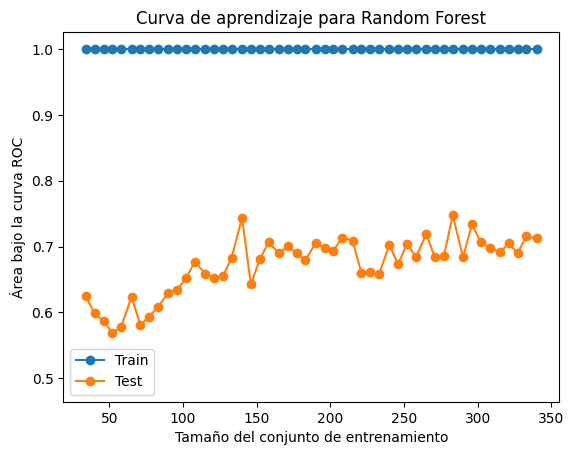

In [135]:
params = {"max_features": cant_features[np.argmin(test_auroc_rf)], "n_estimators": 200}
RF = RandomForestClassifier(**params)
play = LearningCurveDisplay.from_estimator(RF, x, y, train_sizes = np.linspace(0.1, 1.0, 50), cv=skf, line_kw = {"marker": "o"}, scoring='roc_auc')

ax = plt.gca()

for collection in ax.collections:
    collection.set_alpha(0)

plt.title('Curva de aprendizaje para Random Forest')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Área bajo la curva ROC')
plt.show()

## Ejercicio 5: 
### Evaluación de performance

- La entrega del trabajo estará acompañada de una evaluación en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

- Su tarea será estimar la performance (AUCROC) que tendrá su mejor modelo en datos de evaluación (X_held_out). 

- Para ello, deberán predecir las **probabilidades** de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUCROC resultante y calcularemos el resultado real. Consideraremos que el **mejor modelo será el que se encuentre más cerca del valor real que calcularemos luego de la entrega**.

- Recomendamos no perder de vista esta evaluación/competencia durante el desarrollo del TP, sobretodo en el momento de separar los datos en los primeros puntos. 

- Para que podamos evaluar la performance, junto con la entrega del informe, deberán enviar un archivo con el numero de grupo con dos digitos en formato csv con la columna `output` y el valor obtenido con 4 decimales (se subirá un ejemplo cuando se publiquen los datos de la competencia) y un valor esperado de AUCROC: `GG_y_pred_held_out_AUCROC`. 

    - Ej.: el grupo tres cree que obtuvo un valor de 0.7321 de AUCROC deberá submitear un archivo llamado: `03_y_pred_held_out_7321.csv`.

- Los datos podrán encontrarlos en este [link](https://github.com/aprendizaje-automatico-dc-uba-ar/material/tree/main/tp/01_aprendizaje_supervisado/datos).

- Las decisiones de este punto pueden desarrollarse hasta en una carilla, aunque con media debería alcanzar.


Primero revisemos la performance de cada modelo, así vemos cual nos dio mejor

In [136]:
print(mejor_modelo_arbol['parametros'].values[0])
print("AUROC del mejor modelo de arbol de decision:", mejor_modelo_arbol['mean_AUROC'].values[0])
print(mejor_modelo_svm['parametros'].values[0])
print("AUROC del mejor modelo de SVM:",mejor_modelo_svm['mean_AUROC'].values[0])
print(mejor_modelo_lda['parametros'].values[0])
print("AUROC del mejor modelo de LDA:",mejor_modelo_lda['mean_AUROC'].values[0])
print(mejor_modelo_knn['parametros'].values[0])
print("AUROC del mejor modelo de KNN:",mejor_modelo_knn['mean_AUROC'].values[0])
print(mejor_modelo_bayes['parametros'].values[0])
print("AUROC del mejor modelo de Naive Bayes:",mejor_modelo_bayes['mean_AUROC'].values[0])


{'criterion': 'entropy', 'max_depth': 3}
AUROC del mejor modelo de arbol de decision: 0.6467624437817306
{'C': 4.344, 'degree': 4, 'kernel': 'rbf'}
AUROC del mejor modelo de SVM: 0.8919956507332311
{}
AUROC del mejor modelo de LDA: 0.7534190531852717
{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
AUROC del mejor modelo de KNN: 0.842863838977223
{'priors': array([0.5, 0.5]), 'var_smoothing': 0.0009184478488708967}
AUROC del mejor modelo de Naive Bayes: 0.8227818656223098


Para ver cual es el mejor modelo, nos parece relevante graficar las curvas de complejidad de los mejores modelos de KNN ya que vemos que el mejor modelo dió un valor cercano al de SVM en el valor del área de la curva ROC

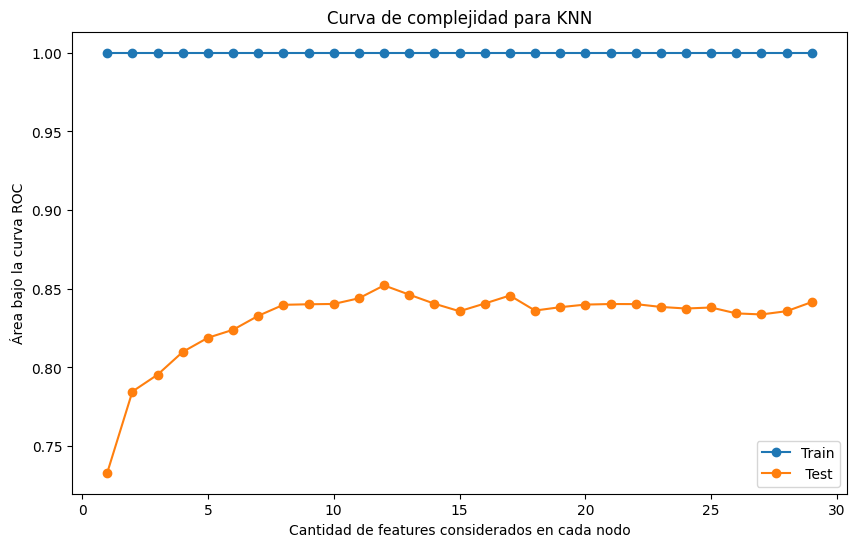

In [137]:
train_auroc_knn = []
test_auroc_knn = []
cant_features = range(1, 30)

for vecino in range(1,30):
    train_auroc, test_auroc = auroc_complejidad(KNeighborsClassifier, params={"n_neighbors": vecino,'p': 1, 'weights': 'distance'})
    train_auroc_knn = np.append(train_auroc_knn, train_auroc)
    test_auroc_knn = np.append(test_auroc_knn, test_auroc)


plt.figure(figsize=(10, 6))
plt.plot(cant_features, train_auroc_knn, label='Train', marker='o')
plt.plot(cant_features, test_auroc_knn, label=' Test', marker='o')
plt.xlabel('Cantidad de features considerados en cada nodo')
plt.ylabel('Área bajo la curva ROC')
plt.title('Curva de complejidad para KNN')
plt.legend()
plt.show()

In [138]:
print('Cantidad de vecinos donde se alcanza el mayor valor de AUROC:', np.argmax(test_auroc_knn))
print('Valor de AUROC para la cantidad de vecinos que maximiza este valor:', max(test_auroc_knn))

Cantidad de vecinos donde se alcanza el mayor valor de AUROC: 11
Valor de AUROC para la cantidad de vecinos que maximiza este valor: 0.8521578157755831


Vemos que el modelo con mayor auroc es el de cantidad de vecinos = 12, que no lo habíamos tenido en cuenta cuando hicimos el randomized search. Sin embargo, este valor de AUROC sigue siendo más chico que el de SVM.


##### Predecimos entonces con nuestro mejor modelo, que es SVM, a todo el conjunto de evaluación separado en el ejercicio 1 

In [139]:
eval = pd.read_csv("evaluacion.csv")

Entrenamos el modelo con los hiperparámetros previamente encontrados y los datos de entrenamiento y predecimos los de evaluación

In [140]:
params_svc = mejor_modelo_svm['parametros'].values[0]
params_svc['probability'] = True
svm1 = svm.SVC(**params_svc)
svm1.fit(x, y)
predicciones_eval = svm1.predict(eval.drop('target', axis=1))

In [141]:
auroc = roc_auc_score(eval['target'], predicciones_eval)
print("AUROC para los datos de evaluación:", auroc)

AUROC para los datos de evaluación: 0.8137254901960783


##### Ahora predecimos el conjunto X_held_out

In [142]:
x_held = pd.read_csv("X_held_out.csv")

In [143]:
probas_held_out = svm1.predict_proba(x_held)[:,0]
probas_held_out

array([0.5915594 , 0.95735287, 0.57850026, 0.7834533 , 0.87002021,
       0.96624467, 0.97011958, 0.851687  , 0.825814  , 0.62614147,
       0.95840264, 0.8182531 , 0.99527061, 0.90264951, 0.89105945,
       0.96173881, 0.91610468, 0.72186539, 0.78752831, 0.9170671 ,
       0.98150394, 0.98611544, 0.97398376, 0.69406528, 0.98753785,
       0.01980192, 0.40506849, 0.86521649, 0.94580837, 0.06712093,
       0.84340195, 0.09608318, 0.0757468 , 0.80369979, 0.12594646,
       0.19068816, 0.6197674 , 0.95561261, 0.19584881, 0.89805636,
       0.06718394, 0.73183094, 0.53910221, 0.78245751, 0.9199486 ,
       0.7297327 , 0.96926707, 0.98213495, 0.9599936 , 0.93888055,
       0.19572804, 0.86013145, 0.73218048, 0.95420197, 0.66805084,
       0.53532563, 0.35336783, 0.86762409, 0.06520779, 0.69997945,
       0.93998074, 0.9603648 , 0.98886427, 0.80909232, 0.7709536 ,
       0.48122222, 0.94723119, 0.76131558, 0.65712168, 0.89225622,
       0.73408039, 0.92917378, 0.98085061, 0.48931387, 0.55634

Guardemoslo en un archivo .csv, donde redondeamos las estimaciones con 4 decimales

In [144]:
df_probas_clase_0 = pd.DataFrame(probas_held_out, columns=['output'])

df_probas_clase_0.to_csv('02_y_pred_held_out_0.8137.csv', index=False, float_format='%.4f')

## Ejercicio 6: 
### Conclusiones

Dar en a lo sumo 2 carillas una conclusión del trabajo realizado, incluyendo problemas encontrados y 
dimensiones no incluidas en el enunciado que hayan sido abordadas durante el desarrollo.

---
## Entregables
- Contarán con un esqueleto en formato Jupyter Notebook en donde podrán intercalar celdas para reportar y responder a los ítems de cada ejercicio. 
- Los entregrables serán
    - Un informe en formato .pdf (**digital**) que responda a los ítems de este enunciado respetando la cantidad de espacio máximo por cada ítem. Nombrarlo siguiendo el formato `GG_Nombre_de_grupo`
    - Adjuntar el notebook final en formatos .pdf e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (verificarlo haceindo: Kernel -> Restart and Run All). 
    - Las predicciones del *held out* del punto 5 en formato csv.
- Habŕa una entrega intermedia obligatoria que deberán hacer antes del 25 de abril de 2024 a las 23:55hs. Para esta entrega deberán enviar el código que resuelve los primeros 3 ejercicios. 
- La **fecha** y **hora límite** de entrega está determinada en el campus de la materia.
- El trabajo deberá elaborarse en grupos de hasta 4 personas (4 preferentemente).
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.


### Importante: sobre el uso de ChatGPT y grandes modelos de lenguaje

En este trabajo no estará explícitamente prohibido pero si fuertemente desaconsejado, consideramos a este trabajo práctico una importante herramienta de aprendizaje donde el uso de GPT puede ser perjudicial. En caso de usarlo se pide aclararlo en el informe y especificar cómo y en donde se utilizó. Así como expresar su opinión sobre la respuesta generada por el modelo pudiendo estar a favor o en contra de lo propuesto por este. Pueden adjuntar el link a la conversación con el modelo.

**Nota**: Agradecemos a [Martín García Sola](https://ar.linkedin.com/in/martin-e-garcia-sola) por la asistencia biológica en la confección de este Trabajo Práctico.